# Optimal Control

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import qutip_qtrl.pulseoptim as cpo
import scqubits as scq

In [ ]:
levels = 6
fluxonium = scq.Fluxonium(EJ=8.9, EC=2.5, EL=0.5, flux=0.48, cutoff=110)
c_ops = None  # will be initialized once below

In [ ]:
def init_c_ops():
    gamma_ij = {}
    for j in range(1, levels):
        for i in range(j):
            t1 = fluxonium.t1_capacitive(j, i, Q_cap=1e5, total=False)
            if t1 is not None and t1 > 0:
                rate = 1.0 / t1
                gamma_ij[(i, j)] = rate
                gamma_ij[(j, i)] = rate
    c_ops_local = []
    for (i, j), gamma in gamma_ij.items():
        cop = np.sqrt(gamma) * qt.basis(levels, i) * qt.basis(levels, j).dag()
        c_ops_local.append(cop)
    return c_ops_local

In [ ]:
scq.settings.T1_DEFAULT_WARNING=False


if c_ops is None:
    c_ops = init_c_ops()

evals, evecs = fluxonium.eigensys(evals_count=levels)
n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))
H0 = qt.Qobj(np.diag(evals))
A = 0.1
drive_op = n_op_energy_basis
H = [H0, [A * drive_op, 'cos(wd * t)']]

In [ ]:
def evolve(omega_d, t_g):
    # global c_ops
    # if c_ops is None:
    #     c_ops = init_c_ops()

    # evals, evecs = fluxonium.eigensys(evals_count=levels)
    # n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))
    # H0 = qt.Qobj(np.diag(evals))
    # A = 0.1
    # drive_op = n_op_energy_basis
    # H = [H0, [A * drive_op, 'cos(wd * t)']]
    args = {'wd': omega_d}
    options = qt.Options(nsteps=1000000, store_states=True, atol=1e-10, rtol=1e-9)

    propagator = qt.propagator(H, t_g, args=args, options=options, c_ops=c_ops)
    propagator_kraus = qt.to_kraus(propagator)
    propagator_2x2 = [qt.Qobj(k.full()[:2, :2]) for k in propagator_kraus]
    p_2x2_super = qt.kraus_to_super(propagator_2x2)
    fidelity = qt.average_gate_fidelity(p_2x2_super, qt.sigmax())
    print("completed iteration")
    return fidelity

def wrapped_evolve(args):
    return evolve(*args)


-------------------

## Example Notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
# the library for quantum control
import qutip_qtrl.pulseoptim as cpo

In [3]:
# total duration
T = 2 * np.pi
# number of time steps
times = np.linspace(0, T, 500)

In [ ]:
U_0 = qt.operators.identity(4)
U_target = qt.core.gates.cnot()

In [ ]:
# Drift Hamiltonian
g = 0
H_drift = g * (
    qt.tensor(qt.sigmax(), qt.sigmax()) + qt.tensor(qt.sigmay(), qt.sigmay())
)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [6]:
H_ctrl = [
    qt.tensor(qt.sigmax(), qt.identity(2)),
    qt.tensor(qt.sigmay(), qt.identity(2)),
    qt.tensor(qt.sigmaz(), qt.identity(2)),
    qt.tensor(qt.identity(2), qt.sigmax()),
    qt.tensor(qt.identity(2), qt.sigmay()),
    qt.tensor(qt.identity(2), qt.sigmaz()),
    qt.tensor(qt.sigmax(), qt.sigmax()),
    qt.tensor(qt.sigmay(), qt.sigmay()),
    qt.tensor(qt.sigmaz(), qt.sigmaz()),
]

In [8]:
H_labels = [
    r"$u_{1x}$",
    r"$u_{1y}$",
    r"$u_{1z}$",
    r"$u_{2x}$",
    r"$u_{2y}$",
    r"$u_{2z}$",
    r"$u_{xx}$",
    r"$u_{yy}$",
    r"$u_{zz}$",
]

In [9]:
result = cpo.optimize_pulse_unitary(
    H_drift,
    H_ctrl,
    U_0,
    U_target,
    num_tslots=500,
    evo_time=(2 * np.pi),
    # this attribute is crucial for convergence!!
    amp_lbound=-(2 * np.pi * 0.05),
    amp_ubound=(2 * np.pi * 0.05),
    fid_err_targ=1e-9,
    max_iter=500,
    max_wall_time=60,
    alg="GRAPE",
    optim_method="FMIN_L_BFGS_B",
    method_params={
        "disp": True,
        "maxiter": 1000,
    },
)

In [10]:
for attr in dir(result):
    if not attr.startswith("_"):
        print(f"{attr}: {getattr(result, attr)}")

print(np.shape(result.final_amps))

evo_full_final: Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 7.07110955e-01-7.07102608e-01j  2.24126554e-06-1.91459347e-06j
  -2.14818589e-06+1.21343212e-06j  6.16981999e-06-3.54727909e-06j]
 [-1.91459820e-06+2.24133440e-06j  7.07104198e-01-7.07109365e-01j
  -4.69608272e-06+1.97919694e-06j  1.01590309e-06-9.23836642e-06j]
 [-3.54722522e-06+6.16980118e-06j -9.23834823e-06+1.01598289e-06j
   6.87220985e-06-7.63862492e-06j  7.07100812e-01-7.07112750e-01j]
 [ 1.21349311e-06-2.14821834e-06j  1.97930825e-06-4.69608915e-06j
   7.07111160e-01-7.07102403e-01j -7.63861011e-06+6.87216898e-06j]]
evo_full_initial: Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 9.97233855e-01+0.03184367j  2.08665249e-02-0.00987838j
   2.45333691e-02-0.02077947j  4.21299892e-03-0.05409439j]
 [-2.21338152e-02-0.01091704j  9.98264520e-01-0.04056235j
  -2.22024272e-03-0.01069856j  2.85788837e-02-0.01665576j]
 [-

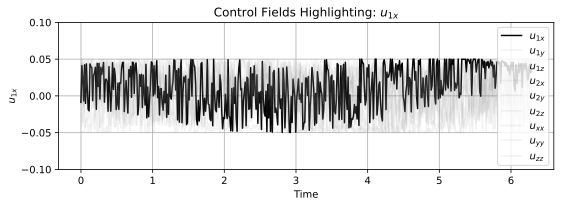

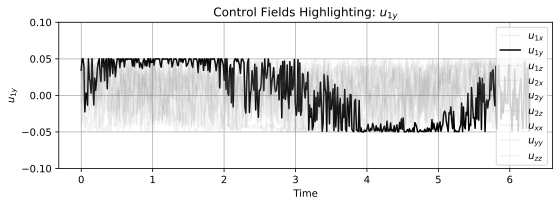

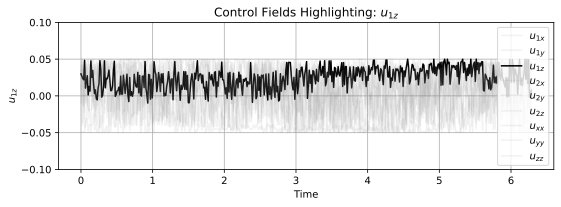

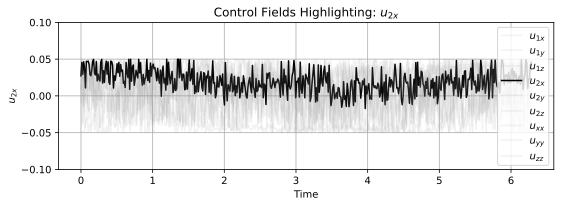

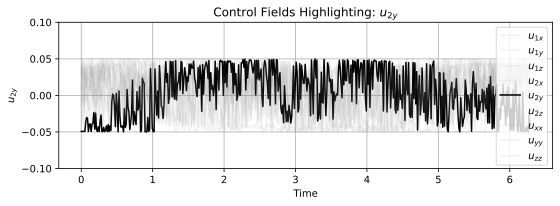

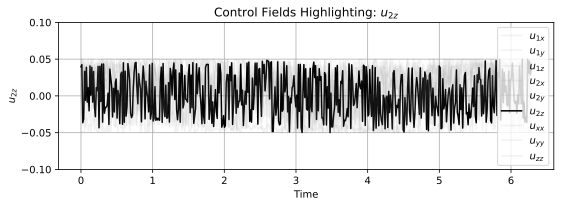

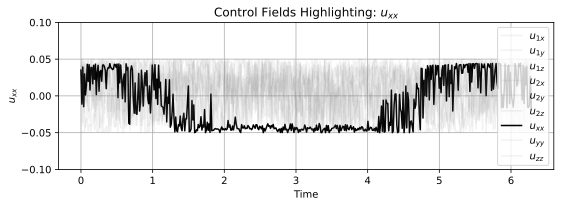

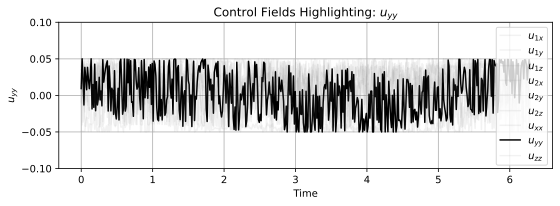

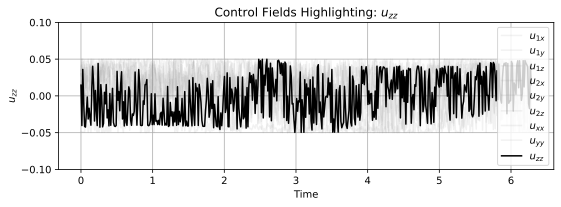

In [11]:
def plot_control_amplitudes(times, final_amps, labels):
    num_controls = final_amps.shape[1]

    y_max = 0.1  # Fixed y-axis scale
    y_min = -0.1

    for i in range(num_controls):
        fig, ax = plt.subplots(figsize=(8, 3))

        for j in range(num_controls):
            # Highlight the current control
            color = "black" if i == j else "gray"
            alpha = 1.0 if i == j else 0.1
            ax.plot(
                times,
                final_amps[:, j],
                label=labels[j],
                color=color,
                alpha=alpha
                )
        ax.set_title(f"Control Fields Highlighting: {labels[i]}")
        ax.set_xlabel("Time")
        ax.set_ylabel(labels[i])
        ax.set_ylim(y_min, y_max)  # Set fixed y-axis limits
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()


plot_control_amplitudes(times, result.final_amps / (2 * np.pi), H_labels)

In [12]:
U_target

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

In [13]:
U_f = result.evo_full_final
U_f.dims = [[2, 2], [2, 2]]

In [14]:
U_f

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 7.07110955e-01-7.07102608e-01j  2.24126554e-06-1.91459347e-06j
  -2.14818589e-06+1.21343212e-06j  6.16981999e-06-3.54727909e-06j]
 [-1.91459820e-06+2.24133440e-06j  7.07104198e-01-7.07109365e-01j
  -4.69608272e-06+1.97919694e-06j  1.01590309e-06-9.23836642e-06j]
 [-3.54722522e-06+6.16980118e-06j -9.23834823e-06+1.01598289e-06j
   6.87220985e-06-7.63862492e-06j  7.07100812e-01-7.07112750e-01j]
 [ 1.21349311e-06-2.14821834e-06j  1.97930825e-06-4.69608915e-06j
   7.07111160e-01-7.07102403e-01j -7.63861011e-06+6.87216898e-06j]]

In [15]:
print(f"Fidelity: {qt.process_fidelity(U_f, U_target)}")


Fidelity: 0.999999999818866


---------------------

## New Data

need to be careful when truncating the dimension to calculate the fidelity, but to start with I can make a system with three levels where U ideal is X on the lowest two and then identity on the last one

In the original workflow, these are the two examples used

In [16]:
U_0 = qt.operators.identity(4)

U_0

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dia, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

In [17]:
U_target = qt.core.gates.cnot()

U_target


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

But we are using this:

In [18]:
levels = 3
fluxonium = scq.Fluxonium(EJ=8.9, EC=2.5, EL=0.5, flux=0.48, cutoff=110)

In [20]:
def init_c_ops():
    gamma_ij = {}
    for j in range(1, levels):
        for i in range(j):
            t1 = fluxonium.t1_capacitive(j, i, Q_cap=1e5, total=False)
            if t1 is not None and t1 > 0:
                rate = 1.0 / t1
                gamma_ij[(i, j)] = rate
                gamma_ij[(j, i)] = rate
    c_ops_local = []
    for (i, j), gamma in gamma_ij.items():
        cop = np.sqrt(gamma) * qt.basis(levels, i) * qt.basis(levels, j).dag()
        c_ops_local.append(cop)
    return c_ops_local

c_ops = init_c_ops()
scq.settings.T1_DEFAULT_WARNING=False



In [21]:
evals, evecs = fluxonium.eigensys(evals_count=levels)
n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))
H0 = qt.Qobj(np.diag(evals))
A = 0.1
drive_op = n_op_energy_basis

In [22]:
U_0 = H0
U_0

Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-0.70018338  0.          0.        ]
 [ 0.         -0.1893103   0.        ]
 [ 0.          0.          8.75185302]]

In [25]:
U_target = qt.Qobj([[0, 1, 0],
         [1, 0, 0],
         [0, 0, 1]])

#done manually to make it easier to read, not scalable at the moment

recall that the control is defined as this previously

In [27]:
H_ctrl = [
    qt.tensor(qt.sigmax(), qt.identity(2)),
    qt.tensor(qt.sigmay(), qt.identity(2)),
    qt.tensor(qt.sigmaz(), qt.identity(2)),
    qt.tensor(qt.identity(2), qt.sigmax()),
    qt.tensor(qt.identity(2), qt.sigmay()),
    qt.tensor(qt.identity(2), qt.sigmaz()),
    qt.tensor(qt.sigmax(), qt.sigmax()),
    qt.tensor(qt.sigmay(), qt.sigmay()),
    qt.tensor(qt.sigmaz(), qt.sigmaz()),
]

but this is only applicable to a 2 dimensional hilbert space. To go to 3 dimensions we need the gell-mann matrices

In [29]:
lambda_1 = qt.Qobj([[0, 1, 0],
                    [1, 0, 0],
                    [0, 0, 0]])

lambda_2 = qt.Qobj([[0, -1j, 0],
                    [1j,  0, 0],
                    [0,   0, 0]])

lambda_3 = qt.Qobj([[1,  0,  0],
                    [0, -1,  0],
                    [0,  0,  0]])

lambda_4 = qt.Qobj([[0, 0, 1],
                    [0, 0, 0],
                    [1, 0, 0]])

lambda_5 = qt.Qobj([[0,  0, -1j],
                    [0,  0,  0],
                    [1j, 0,  0]])

lambda_6 = qt.Qobj([[0, 0, 0],
                    [0, 0, 1],
                    [0, 1, 0]])

lambda_7 = qt.Qobj([[0,  0,  0],
                    [0,  0, -1j],
                    [0,  1j, 0]])

lambda_8 = qt.Qobj((1/np.sqrt(3)) * np.array([[1, 0, 0],
                                              [0, 1, 0],
                                              [0, 0, -2]]))

# Example: Put all into a list
gell_mann_matrices = [lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8]

H_ctrl = gell_mann_matrices

In [35]:
H_drift = g * (
    qt.tensor(lambda_1, lambda_1) + qt.tensor(lambda_2, lambda_2)
)

H_drift

Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

### Actually results run

In [34]:
result = cpo.optimize_pulse_unitary(
    H_drift, #currently zero
    H_ctrl,
    U_0,
    U_target,
    num_tslots=500,
    evo_time=(2 * np.pi),
    amp_lbound=-(2 * np.pi * 0.05),
    amp_ubound=(2 * np.pi * 0.05),
    fid_err_targ=1e-9,
    max_iter=500,
    max_wall_time=60,
    alg="GRAPE",
    optim_method="FMIN_L_BFGS_B",
    method_params={
        "disp": True,
        "maxiter": 1000,
    },
)

ValueError: incompatible dimensions [[3, 3], [3, 3]] and [[3], [3]]